In [99]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from itertools import product
import random
import os

seed=22
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.config.experimental.enable_op_determinism()

# 指定 GPU 设备
physical_devices = tf.config.list_physical_devices('GPU') 
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# 检查是否设置了 GPU
print("Num GPUs Available: ", len(physical_devices))

# 余下的代码与你的原始代码保持不变


Num GPUs Available:  1


In [100]:
start_date = 20180101
end_date = 20190601
size=9601

start_time = pd.Timestamp(str(start_date))
end_time = pd.Timestamp(str(end_date))


# 读取数据
priceFile='./price/DailyUSDPrice.xlsx'
price = pd.read_excel(priceFile,header=None)

# 将第 0 列转换为 datetime 类型
price[0] = pd.to_datetime(price[0])

price=price[(price[0] >= start_time) & (price[0] < end_time)]

# 将第 0 列设置为索引
price.set_index(0, inplace=True)

price=price/1000

# 重命名列
price.columns = ['price']

# 显示 DataFrame
print(price)

              price
0                  
2018-01-01  1.29100
2018-01-02  1.31205
2018-01-03  1.31490
2018-01-04  1.31450
2018-01-05  1.31715
...             ...
2019-05-27  1.28250
2019-05-28  1.27830
2019-05-29  1.28165
2019-05-30  1.28095
2019-05-31  1.29555

[516 rows x 1 columns]


In [101]:
others=['new消费者价格指数','new利率','new道琼斯工业平均指数历史数据']
otherData=pd.DataFrame()
for i in others:
    file='./newCsv/'+i+'.csv'
    df=pd.read_csv(file)
    df.columns=[0,1]
    df[0] = pd.to_datetime(df[0], format='%Y-%m-%d')
    
    df=df[(df[0] >= start_time) & (df[0] < end_time)]
    
    df.set_index(0, inplace=True)
    # print(df)
    
    # 横向合并三个 DataFrame
    otherData= pd.concat([otherData,df], axis=1)


otherData.columns=['消费者','利率','道琼斯']
# 显示合并后的 DataFrame
print(otherData)

                   消费者     利率         道琼斯
0                                        
2018-01-01  247.867000  0.015  24797.8125
2018-01-02  247.903258  0.015  24824.0100
2018-01-03  247.939516  0.015  24922.6800
2018-01-04  247.975774  0.015  25075.1300
2018-01-05  248.012032  0.015  25295.8700
...                ...    ...         ...
2019-05-27  256.134774  0.025  25407.2500
2019-05-28  256.136419  0.025  25347.7700
2019-05-29  256.138065  0.025  25126.4100
2019-05-30  256.139710  0.025  25169.8800
2019-05-31  256.141355  0.025  24815.0400

[516 rows x 3 columns]


In [102]:

file='./newCsv/'+str(size)+'_'+str(start_date)+'_to_'+str(end_date)+'.csv'
GDELT=pd.read_csv(file,header=None)
GDELT[0] = pd.to_datetime(GDELT[0], format='%Y%m%d')
GDELT=GDELT[(GDELT[0] >= start_time) & (GDELT[0] < end_time)]
GDELT.set_index(0, inplace=True)
print(GDELT)


            1     2     3         4     5     6     7         8     9     \
0                                                                          
2018-01-01   1.0   0.0  14.0 -2.514881   1.0   1.9   4.0 -2.514881   1.0   
2018-01-02   1.0   4.0   5.0  2.447552   1.0   2.8   5.0  2.447552   1.0   
2018-01-03   3.0  -2.0  20.0 -3.860219   1.0   1.9  10.0 -6.752412   2.0   
2018-01-04   1.0   3.0  10.0 -8.148148   1.0   1.9  10.0 -1.931519   3.0   
2018-01-05   1.0   3.4   4.0 -0.920245   1.0   1.9   2.0 -6.172840   1.0   
...          ...   ...   ...       ...   ...   ...   ...       ...   ...   
2019-05-27   1.0   2.8   2.0  2.747253   1.0   2.8   2.0  2.786885   1.0   
2019-05-28   1.0   2.8   2.0 -3.266788   3.0  -4.0  10.0 -0.203252   1.0   
2019-05-29   1.0   0.0   1.0 -3.871829   1.0   0.0   1.0 -3.871829   1.0   
2019-05-30   1.0   0.0   1.0  5.288462   1.0   0.0   1.0  5.288462   1.0   
2019-05-31   1.0   1.9  10.0 -3.896104   1.0   1.9   6.0 -3.896104   1.0   

           

In [103]:
Y=price['price']
print(Y)

0
2018-01-01    1.29100
2018-01-02    1.31205
2018-01-03    1.31490
2018-01-04    1.31450
2018-01-05    1.31715
               ...   
2019-05-27    1.28250
2019-05-28    1.27830
2019-05-29    1.28165
2019-05-30    1.28095
2019-05-31    1.29555
Name: price, Length: 516, dtype: float64


In [104]:

X=pd.concat([otherData,GDELT], axis=1)
X.columns = X.columns.astype(str) 

# 归一化数据
scaler = MinMaxScaler()
X = X.fillna(0)
X= pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print(X)

          消费者   利率       道琼斯         1      2         3         4         5  \
0    0.000000  0.0  0.596803  0.000000  0.500  0.188406  0.514581  0.000000   
1    0.004382  0.0  0.602005  0.000000  0.700  0.057971  0.699467  0.000000   
2    0.008764  0.0  0.621597  0.666667  0.400  0.275362  0.464458  0.000000   
3    0.013146  0.0  0.651868  0.000000  0.650  0.130435  0.304702  0.000000   
4    0.017528  0.0  0.695699  0.000000  0.670  0.043478  0.573993  0.000000   
..        ...  ...       ...       ...    ...       ...       ...       ...   
511  0.999205  1.0  0.717814  0.000000  0.640  0.014493  0.710633  0.000000   
512  0.999404  1.0  0.706004  0.000000  0.640  0.014493  0.486568  0.666667   
513  0.999602  1.0  0.662050  0.000000  0.500  0.000000  0.464026  0.000000   
514  0.999801  1.0  0.670682  0.000000  0.500  0.000000  0.805311  0.000000   
515  1.000000  1.0  0.600224  0.000000  0.595  0.130435  0.463121  0.000000   

         6         7  ...      9591      9592      

In [105]:
# 将数据集划分为训练集、验证集和测试集
train_size = int(len(X) * 0.7)
valid_size = int(len(X) * 0.2)
test_size = len(X) - train_size - valid_size

X_train, Y_train= X[:train_size],Y[:train_size]
X_valid, Y_valid= X[train_size:(train_size + valid_size)], Y[train_size:(train_size + valid_size)]
X_test, Y_test= X[(train_size + valid_size):], Y[(train_size + valid_size):]


In [106]:


def getLossAndPredictions(epochs,batch_size):
    
    # 2. 构建 LSTM 模型
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1],1)))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    
    # 3. 模型编译
    model.compile(optimizer='adam', loss='mean_squared_error')
    # model.compile(optimizer='adam', loss='mean_absolute_error')

    # 4. 模型训练
    model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, Y_valid))
    
    # 5. 模型评估
    loss = model.evaluate(X_test, Y_test)
    # 6. 模型应用（例如，进行预测）
    predictions = model.predict(X_test)
    
    return [loss,predictions]
    

In [107]:
result=list()

param_grid = {
    'epochs': [50,10,5],
    'batch_size':[32,16,64]
}

# param_grid = {
#     'epochs': [50],
#     'batch_size':[32]
# }

param_combinations = list(product(param_grid['epochs'], param_grid['batch_size']))

print(param_combinations)
best_score = 2*32
best_params = None

for params in param_combinations:
    epochs,batch_size = params
    score,y_pred=getLossAndPredictions(epochs,batch_size)
    result.append([params,score,y_pred])
    if score < best_score:
        best_score = score
        best_params = params
print(best_score)
print(best_params)

[(50, 32), (50, 16), (50, 64), (10, 32), (10, 16), (10, 64), (5, 32), (5, 16), (5, 64)]
Epoch 1/50
12/12 [==============================] - 18s 1s/step - loss: 1.3113 - val_loss: 0.3608
Epoch 2/50
12/12 [==============================] - 14s 1s/step - loss: 0.1081 - val_loss: 0.0715
Epoch 3/50
12/12 [==============================] - 14s 1s/step - loss: 0.0399 - val_loss: 0.0067
Epoch 4/50
12/12 [==============================] - 14s 1s/step - loss: 0.0136 - val_loss: 0.0156
Epoch 5/50
12/12 [==============================] - 14s 1s/step - loss: 0.0092 - val_loss: 0.0051
Epoch 6/50
12/12 [==============================] - 15s 1s/step - loss: 0.0065 - val_loss: 0.0082
Epoch 7/50
12/12 [==============================] - 14s 1s/step - loss: 0.0061 - val_loss: 0.0053
Epoch 8/50
12/12 [==============================] - 14s 1s/step - loss: 0.0058 - val_loss: 0.0070
Epoch 9/50
12/12 [==============================] - 14s 1s/step - loss: 0.0056 - val_loss: 0.0043
Epoch 10/50
12/12 [===========

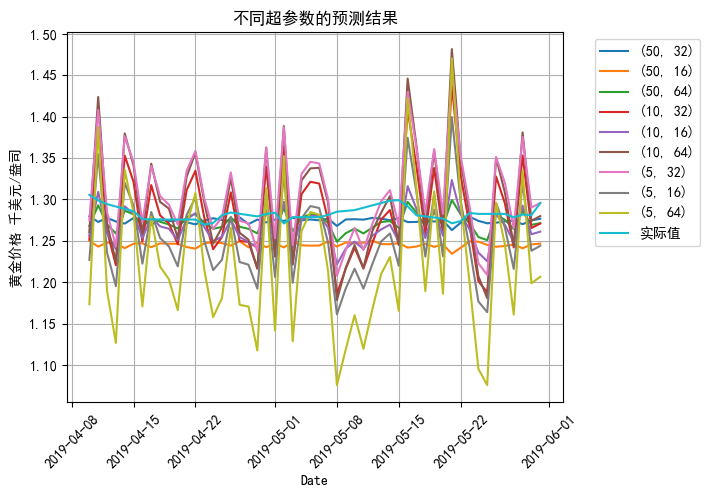

In [108]:

# 显示网格
plt.grid(True)
plt.xticks(rotation=45)
# 设置y轴范围
# plt.ylim(1, 1.5)  

plt.rcParams['font.family'] = 'SimHei'  # 替换为你选择的字体

for i in result:
    label,loss,predictions=i
    plt.plot(Y_test.index,predictions,label=str(label))
    # print('Test Loss:', loss)

# 绘制折线图
plt.plot(Y_test.index, Y_test,label='实际值')

plt.title('不同超参数的预测结果')
plt.xlabel('Date')
plt.ylabel('黄金价格 千美元/盎司')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 显示图形
plt.show()
        

In [113]:
result0=result[:3]
result1=result[3:6]
result2=result[6:]

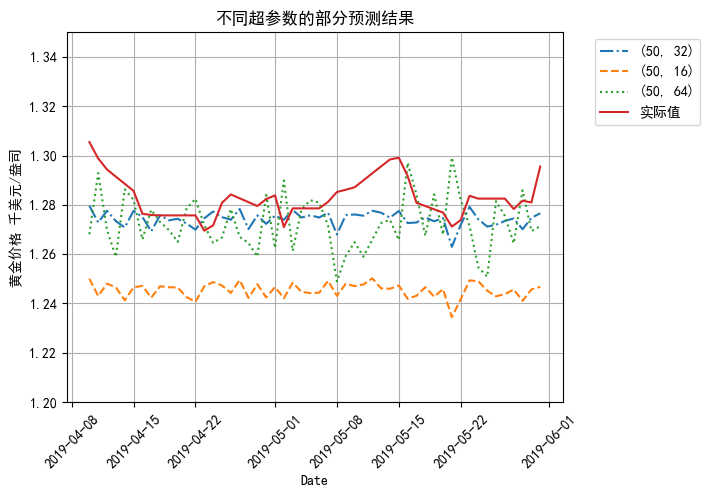

In [122]:

# 显示网格
plt.grid(True)
plt.xticks(rotation=45)
# 设置y轴范围
plt.ylim(1.2, 1.35)  

plt.rcParams['font.family'] = 'SimHei'  # 替换为你选择的字体

linestyles=['-.','--',':' ]
for i in range(3):
    linestyle=linestyles[i]
    label,loss,predictions=result0[i]
    plt.plot(Y_test.index,predictions,label=str(label),linestyle=linestyle)
    # print('Test Loss:', loss)

# 绘制折线图
plt.plot(Y_test.index, Y_test,label='实际值',linestyle='-')

plt.title('不同超参数的部分预测结果')
plt.xlabel('Date')
plt.ylabel('黄金价格 千美元/盎司')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 显示图形
plt.show()

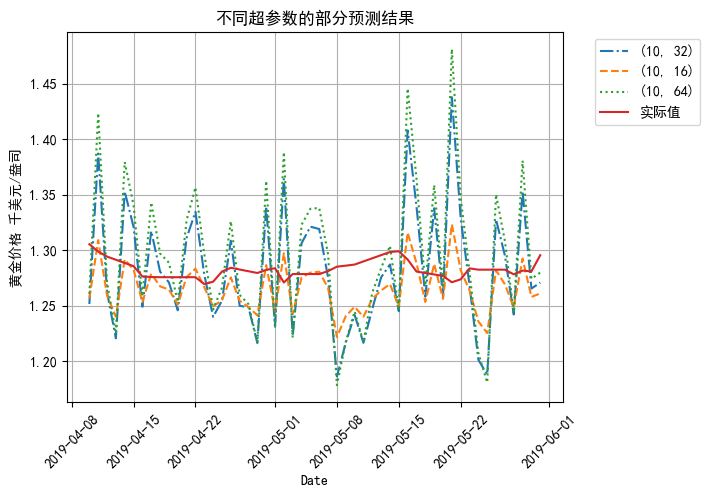

In [124]:

# 显示网格
plt.grid(True)
plt.xticks(rotation=45)
# 设置y轴范围
# plt.ylim(1.2, 1.35)  

plt.rcParams['font.family'] = 'SimHei'  # 替换为你选择的字体

linestyles=['-.','--',':' ]
for i in range(3):
    linestyle=linestyles[i]
    label,loss,predictions=result1[i]
    plt.plot(Y_test.index,predictions,label=str(label),linestyle=linestyle)
    # print('Test Loss:', loss)

# 绘制折线图
plt.plot(Y_test.index, Y_test,label='实际值',linestyle='-')

plt.title('不同超参数的部分预测结果')
plt.xlabel('Date')
plt.ylabel('黄金价格 千美元/盎司')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 显示图形
plt.show()

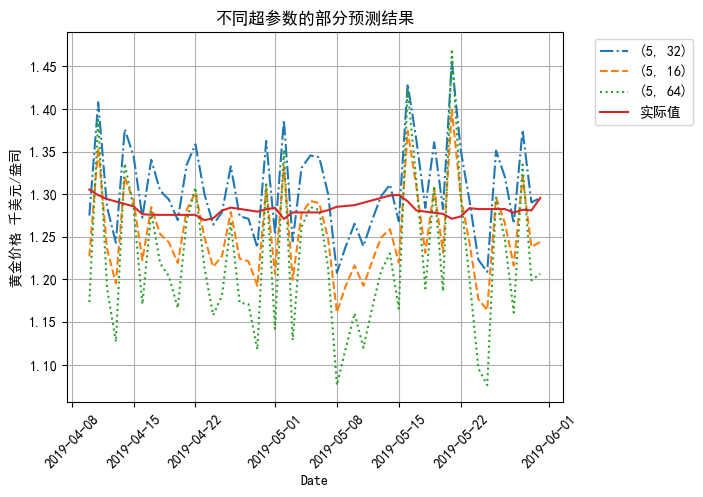

In [125]:

# 显示网格
plt.grid(True)
plt.xticks(rotation=45)
# 设置y轴范围
# plt.ylim(1.2, 1.35)  

plt.rcParams['font.family'] = 'SimHei'  # 替换为你选择的字体

linestyles=['-.','--',':' ]
for i in range(3):
    linestyle=linestyles[i]
    label,loss,predictions=result2[i]
    plt.plot(Y_test.index,predictions,label=str(label),linestyle=linestyle)
    # print('Test Loss:', loss)

# 绘制折线图
plt.plot(Y_test.index, Y_test,label='实际值',linestyle='-')

plt.title('不同超参数的部分预测结果')
plt.xlabel('Date')
plt.ylabel('黄金价格 千美元/盎司')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 显示图形
plt.show()

In [109]:
for i in result:
    label,loss,predictions=i
    if label[0]==best_params[0] and label[1]==best_params[1]:
         tmp=i
    print(label,loss)

(50, 32) 0.0001318249705946073
(50, 16) 0.001473914016969502
(50, 64) 0.00031598532223142684
(10, 32) 0.0031914934515953064
(10, 16) 0.000868563016410917
(10, 64) 0.004615228157490492
(5, 32) 0.0036720766220241785
(5, 16) 0.0036774449981749058
(5, 64) 0.011255278252065182


In [110]:
XX=otherData
XX = XX.fillna(0)
XX= pd.DataFrame(scaler.fit_transform(XX), columns=XX.columns)
XX_train=XX[:train_size]
XX_valid =XX[train_size:(train_size + valid_size)]
XX_test =XX[(train_size + valid_size):]

epochs=best_params[0]
batch_size=best_params[1]

# 2. 构建 LSTM 模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(XX.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# 3. 模型编译
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(XX_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(XX_valid, Y_valid))

# 5. 模型评估
loss2 = model.evaluate(XX_test, Y_test)

# 6. 模型应用（例如，进行预测）
predictions2 = model.predict(XX_test)

Epoch 1/50
12/12 [==============================] - 5s 81ms/step - loss: 1.4464 - val_loss: 1.1168
Epoch 2/50
12/12 [==============================] - 0s 13ms/step - loss: 0.9374 - val_loss: 0.3184
Epoch 3/50
12/12 [==============================] - 0s 13ms/step - loss: 0.2845 - val_loss: 0.3108
Epoch 4/50
12/12 [==============================] - 0s 14ms/step - loss: 0.1366 - val_loss: 0.1841
Epoch 5/50
12/12 [==============================] - 0s 14ms/step - loss: 0.0793 - val_loss: 0.0357
Epoch 6/50
12/12 [==============================] - 0s 13ms/step - loss: 0.0670 - val_loss: 0.0876
Epoch 7/50
12/12 [==============================] - 0s 13ms/step - loss: 0.0553 - val_loss: 0.0671
Epoch 8/50
12/12 [==============================] - 0s 14ms/step - loss: 0.0459 - val_loss: 0.0377
Epoch 9/50
12/12 [==============================] - 0s 14ms/step - loss: 0.0384 - val_loss: 0.0445
Epoch 10/50
12/12 [==============================] - 0s 15ms/step - loss: 0.0327 - val_loss: 0.0220
Epoch 11/

[(50, 32), 0.0001318249705946073, array([[1.2796198],
       [1.2728254],
       [1.2775922],
       [1.2733653],
       [1.2707863],
       [1.277543 ],
       [1.2750669],
       [1.2692453],
       [1.2757626],
       [1.2736986],
       [1.2743365],
       [1.2723604],
       [1.2699238],
       [1.2745423],
       [1.2772723],
       [1.275001 ],
       [1.2739519],
       [1.2782942],
       [1.2701544],
       [1.2757106],
       [1.2722607],
       [1.2756164],
       [1.2739459],
       [1.2778736],
       [1.2748353],
       [1.2757367],
       [1.274833 ],
       [1.2768018],
       [1.2679304],
       [1.2757989],
       [1.2760707],
       [1.2755779],
       [1.2775973],
       [1.2767924],
       [1.2747992],
       [1.2774644],
       [1.2726012],
       [1.2728096],
       [1.2748594],
       [1.2733178],
       [1.274574 ],
       [1.262933 ],
       [1.271861 ],
       [1.2791507],
       [1.2740921],
       [1.2711661],
       [1.2718904],
       [1.2734681],
      

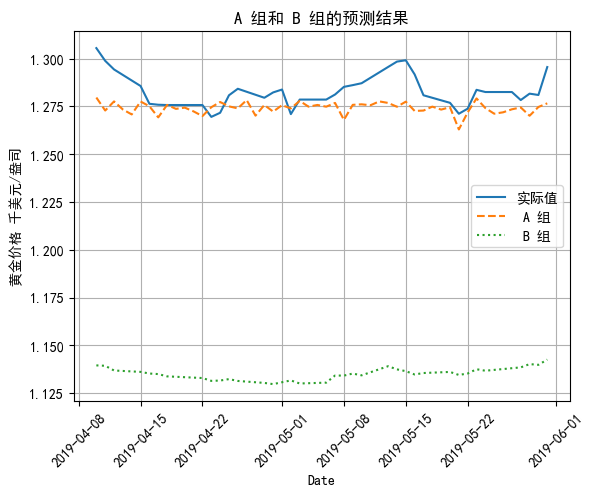

Test Loss1: 0.0001318249705946073
Test Loss2: 0.02194117195904255


In [127]:
tmp=result[0]
for i in result:
    label,loss,predictions=i
    if label[0]==best_params[0] and label[1]==best_params[1]:
         tmp=i
label,loss1,predictions1=tmp
print(tmp)

# 绘制折线图
plt.rcParams['font.family'] = 'SimHei'  # 替换为你选择的字体
plt.plot(Y_test.index, Y_test,label='实际值')
plt.plot(Y_test.index,predictions1,label=' A 组',linestyle='--')
plt.plot(Y_test.index,predictions2,label=' B 组',linestyle=':')

# 显示网格
plt.grid(True)
plt.xticks(rotation=45)

# 设置y轴范围
# plt.ylim(800, 1500)  
plt.legend()

plt.title('A 组和 B 组的预测结果')
plt.xlabel('Date')
plt.ylabel('黄金价格 千美元/盎司')

# 显示图形
plt.show()

print('Test Loss1:', loss1)
print('Test Loss2:', loss2)

In [112]:

j= np.array(Y_test)
for i in [predictions1,predictions2,Y_test]:
    # 示例数组
    data = np.array(i)
    # 计算方差
    variance = np.var(data)
    print("均方差:", variance)
    mae = np.mean(np.abs(j- i))
    print("平均绝对误差:",mae)

均方差: 9.001956e-06
平均绝对误差: 0.009479025467801125
均方差: 9.51459e-06
平均绝对误差: 0.1479691488082592
均方差: 6.36483156640367e-05
平均绝对误差: 0.0
